In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
#from wordcloud import WordCloud

#Input data files are available in the read-only "../input/" directory
#For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [3]:
import pandas as pd

file_path = 'train.txt'  # Replace with your actual file path

# Load the data into a pandas DataFrame
df = pd.read_csv('train.txt', sep=';', header=None, names=['content', 'sentiment'])
df2 = pd.read_csv('val.txt', sep=';', header=None, names=['content', 'sentiment'])
df3 = pd.read_csv('test.txt', sep=';', header=None, names=['content', 'sentiment'])
df = pd.concat([df,df2,df3])
# Strip any leading/trailing whitespace characters from the data
df['content'] = df['content'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# Show the DataFrame
print(df.head())

                                             content sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df.shape

(20000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [7]:
df.isnull().sum()

content      0
sentiment    0
dtype: int64

In [8]:
df.duplicated().sum()

1

In [9]:
#df.drop('tweet_id', axis=1, inplace=True)

In [10]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

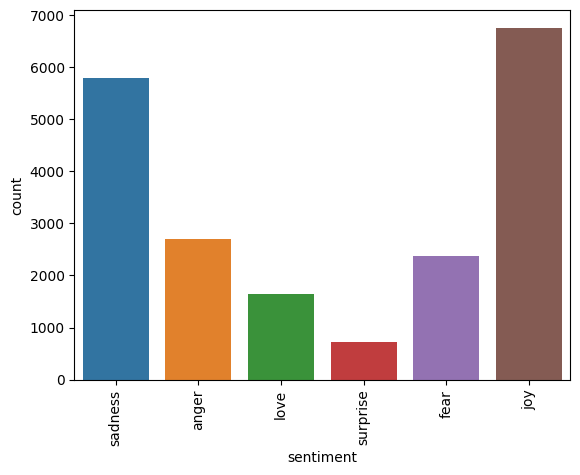

In [11]:
sns.countplot(x=df['sentiment'])
plt.xticks(rotation=90)
plt.show()

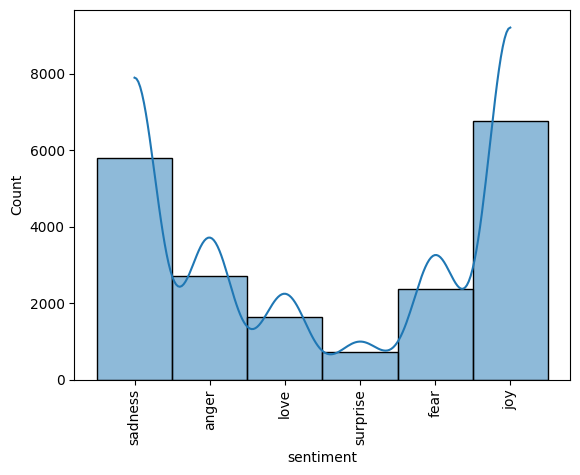

In [12]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/cfm5qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cfm5qc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cfm5qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/cfm5qc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# Remove junk

In [15]:
def text_preprocessing_platform(df, text_col, remove_stopwords=True):

    ## Define functions for individual steps
    # First function is used to denoise text
    def denoise_text(text):
        # Strip html if any. For ex. removing <html>, <p> tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
        # Replace contractions in the text. For ex. didn't -> did not
        text = contractions.fix(text)
        return text

    ## Next step is text-normalization

    # Text normalization includes many steps.

    # Each function below serves a step.


    def remove_non_ascii(words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words


    def to_lowercase(words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words


    def remove_punctuation(words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words


    def replace_numbers(words):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words


    def remove_stopwords(words):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        return new_words


    def stem_words(words):
        """Stem words in list of tokenized words"""
        stemmer = LancasterStemmer()
        stems = []
        for word in words:
            stem = stemmer.stem(word)
            stems.append(stem)
        return stems


    def lemmatize_verbs(words):
        """Lemmatize verbs in list of tokenized words"""
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for word in words:
            lemma = lemmatizer.lemmatize(word, pos='v')
            lemmas.append(lemma)
        return lemmas


    ### A wrap-up function for normalization
    def normalize_text(words, remove_stopwords):
        words = remove_non_ascii(words)
        words = to_lowercase(words)
        words = remove_punctuation(words)
        words = replace_numbers(words)
        if remove_stopwords:
            words = remove_stopwords(words)
        #words = stem_words(words)
        words = lemmatize_verbs(words)
        return words

    # All above functions work on word tokens we need a tokenizer

    # Tokenize tweet into words
    def tokenize(text):
        return nltk.word_tokenize(text)


    # A overall wrap-up function
    def text_prepare(text):
        text = denoise_text(text)
        text = ' '.join([x for x in normalize_text(tokenize(text), remove_stopwords)])
        return text

    # run every-step
    df[text_col] = [text_prepare(x) for x in df[text_col]]


    # return processed df
    return df

In [16]:
df = text_preprocessing_platform(df, 'content', remove_stopwords=True)

In [17]:
df.head()

,content,sentiment
0,feel humiliate,sadness
1,go feel hopeless damn hopeful around someone c...,sadness
2,grab minute post feel greedy wrong,anger
3,ever feel nostalgic fireplace know still property,love
4,feel grouchy,anger


In [18]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

In [19]:
def categorize_sentiment(row):
    if row['sentiment'] in ['sadness', 'anger', 'fear']:
        return 'Concerned'
    #elif row['sentiment'] in ['neutral']:  # Note: 'empty' appears again; check if this is correct.
    #    return 'Neutral'
    elif row['sentiment'] in ['joy', 'love', 'surprise']:
        return 'Not Concerned'
    #elif row['sentiment'] in ['neutral']:
       # return 'Neutral'
    else:
        return 'Undefined'  # Handle any cases that don't fit the above categories

# Apply the function along the rows of the DataFrame
#df['category'] = df.apply(categorize_sentiment, axis=1)

# Balance data

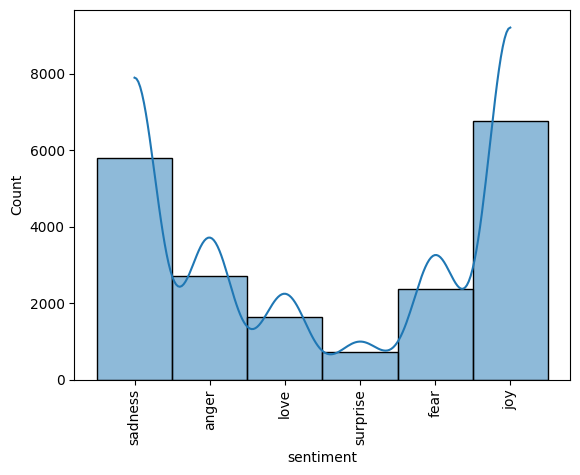

In [20]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [21]:
df['sentiment'].value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: sentiment, dtype: int64

In [22]:
df = df.query('sentiment != "surprise"')

In [23]:
df['sentiment'].value_counts()

joy        6761
sadness    5797
anger      2709
fear       2373
love       1641
Name: sentiment, dtype: int64

In [24]:
#label_mapping = {'Not Concerned': 0, 'Concerned': 1}#, 'Concerned':2}, 'happiness': 2, 'sadness':3, 'love':4, 'surprise':5,'fun':6, 'relief':7, 'hate':8, 'empty':9,
              #  'enthusiasm':10, 'boredom':11,'anger':12}
label_mappping = {'joy':0, 'sadness':1, 'anger':2, 'fear':3, 'love':4}
df['sentiment'] = df['sentiment'].map(label_mappping)


In [25]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print(f'Train: {len(train_df)}; Test: {len(test_df)}')

Train: 13496; Test: 5785


In [26]:
train_df

,content,sentiment
10200,feel thankful everything life every day,0
1875,feel bite like franz liebkind producers many p...,0
50,stand finally stand feel like punish could go ...,1
14921,start feel unsure,3
11467,feel afraid live alone live far,3
...,...,...
11708,feel absolutely overwhelm,3
12417,would feel hesitant use medical system need,3
5623,feel love bless thank allah,4
902,funeral friend kill car accident age,1


In [27]:
X_train = train_df['content'].values
y_train = train_df['sentiment'].values

test_df, val_df = train_test_split(test_df, test_size=0.25)

X_valid = val_df['content'].values
y_valid = val_df['sentiment'].values

X_test = test_df['content'].values
y_test = test_df['sentiment'].values

print(f'X_train: {len(X_train)}; X_test: {len(X_test)}; X_valid: {len(X_valid)}')
print(f'y_train: {len(y_train)}; y_test: {len(y_test)}; y_valid: {len(y_valid)}')

X_train: 13496; X_test: 4338; X_valid: 1447
y_train: 13496; y_test: 4338; y_valid: 1447


In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
labels = np.unique(encoder.inverse_transform(y_train))

In [29]:
labels = df['sentiment'].unique()

In [30]:
from transformers import XLNetForSequenceClassification
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import XLNetTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torch.nn as nn

In [31]:
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=5)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
is_train=True

In [33]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the categories to numerical labels
train_df['sentiment'] = label_encoder.fit_transform(train_df['sentiment'])
test_df['sentiment'] = label_encoder.transform(test_df['sentiment'])
val_df['sentiment'] = label_encoder.transform(val_df['sentiment'])

# Now the categories are numerical, you can convert them to tensors
y_train = torch.tensor(train_df['sentiment'].values)
y_test = torch.tensor(test_df['sentiment'].values)
y_valid = torch.tensor(val_df['sentiment'].values)


In [34]:
# Tokenize and preprocess the text data
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, padding=True, truncation=True)
    return tokens

train_df['TokenizedText'] = train_df['content'].apply(tokenize_text)
test_df['TokenizedText'] = test_df['content'].apply(tokenize_text)
val_df['TokenizedText'] = val_df['content'].apply(tokenize_text)

# Convert tokenized data to PyTorch tensors with padding
X_train = pad_sequence([torch.tensor(seq) for seq in train_df['TokenizedText']], batch_first=True)
y_train = torch.tensor(train_df['sentiment'].tolist())
X_test = pad_sequence([torch.tensor(seq) for seq in test_df['TokenizedText']], batch_first=True)
y_test = torch.tensor(test_df['sentiment'].tolist())
X_valid = pad_sequence([torch.tensor(seq) for seq in val_df['TokenizedText']], batch_first=True)
y_valid = torch.tensor(val_df['sentiment'].tolist())

# Define a DataLoader for batching data
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64)
valid_dataset = TensorDataset(X_valid, y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=64)

# Define the training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

training_loss = []
validation_loss = [] 

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=labels)  # Assuming your model takes 'labels' during training
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

# Define the validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss
# Number of epochs
num_epochs = 10

# Epoch loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    print(f"Training Loss: {train_loss:.4f}")
    training_loss.append(train_loss)
    val_loss = validate(model, valid_dataloader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_loss.append(val_loss)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/10


Training: 100%|██████████| 211/211 [00:44<00:00,  4.73it/s]


Training Loss: 1.5206


Validation: 100%|██████████| 23/23 [00:00<00:00, 39.65it/s]


Validation Loss: 1.4677
Epoch 2/10


Training: 100%|██████████| 211/211 [00:42<00:00,  5.01it/s]


Training Loss: 1.4774


Validation: 100%|██████████| 23/23 [00:00<00:00, 29.85it/s]


Validation Loss: 1.4389
Epoch 3/10


Training: 100%|██████████| 211/211 [00:40<00:00,  5.26it/s]


Training Loss: 1.3414


Validation: 100%|██████████| 23/23 [00:00<00:00, 31.04it/s]


Validation Loss: 1.1582
Epoch 4/10


Training: 100%|██████████| 211/211 [00:41<00:00,  5.08it/s]


Training Loss: 1.0692


Validation: 100%|██████████| 23/23 [00:00<00:00, 39.79it/s]


Validation Loss: 0.9555
Epoch 5/10


Training: 100%|██████████| 211/211 [00:41<00:00,  5.03it/s]


Training Loss: 0.9004


Validation: 100%|██████████| 23/23 [00:00<00:00, 29.94it/s]


Validation Loss: 0.8001
Epoch 6/10


Training: 100%|██████████| 211/211 [00:39<00:00,  5.30it/s]


Training Loss: 0.7682


Validation: 100%|██████████| 23/23 [00:00<00:00, 35.66it/s]


Validation Loss: 0.6804
Epoch 7/10


Training: 100%|██████████| 211/211 [00:41<00:00,  5.04it/s]


Training Loss: 0.6563


Validation: 100%|██████████| 23/23 [00:00<00:00, 25.96it/s]


Validation Loss: 0.6060
Epoch 8/10


Training: 100%|██████████| 211/211 [00:40<00:00,  5.25it/s]


Training Loss: 0.5879


Validation: 100%|██████████| 23/23 [00:00<00:00, 35.09it/s]


Validation Loss: 0.5583
Epoch 9/10


Training: 100%|██████████| 211/211 [00:39<00:00,  5.31it/s]


Training Loss: 0.5395


Validation: 100%|██████████| 23/23 [00:01<00:00, 22.90it/s]


Validation Loss: 0.5217
Epoch 10/10


Training: 100%|██████████| 211/211 [00:42<00:00,  4.99it/s]


Training Loss: 0.4890


Validation: 100%|██████████| 23/23 [00:00<00:00, 36.62it/s]

Validation Loss: 0.4879


In [35]:
def evaluate(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=label_mappping.keys())
    return cm, report

valid_cm, valid_report = evaluate(model, valid_dataloader)
print("Validation Set Evaluation:")
print("Confusion Matrix:")
print(valid_cm)
print("Classification Report:")
print(valid_report)

Validation Set Evaluation:
Confusion Matrix:
[[458  26   9  11  24]
 [  5 374   8  10   2]
 [  7  42 159  11   2]
 [  2  17  12 153   1]
 [ 44   9   2   0  59]]
Classification Report:
              precision    recall  f1-score   support

         joy       0.89      0.87      0.88       528
     sadness       0.80      0.94      0.86       399
       anger       0.84      0.72      0.77       221
        fear       0.83      0.83      0.83       185
        love       0.67      0.52      0.58       114

    accuracy                           0.83      1447
   macro avg       0.80      0.77      0.79      1447
weighted avg       0.83      0.83      0.83      1447



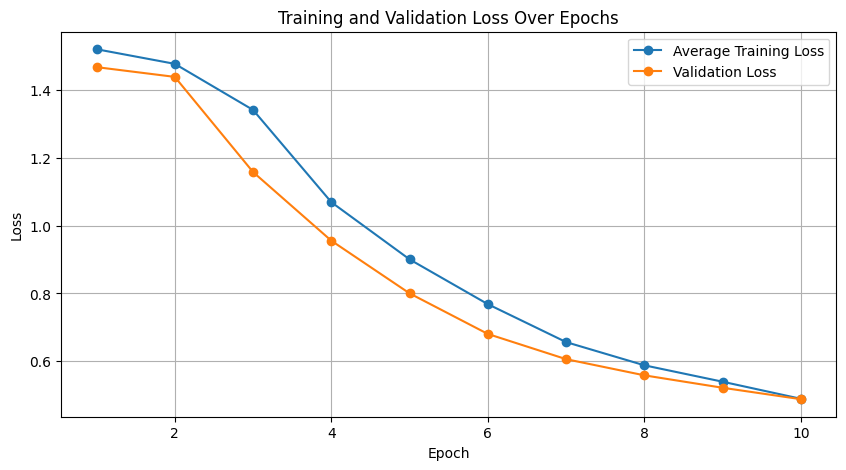

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_over_epochs(train_losses, val_losses):

    if len(train_losses) != len(val_losses):
        raise ValueError("train_losses and val_losses must be of the same length.")
    
    epochs = list(range(1, len(train_losses) + 1))
    
    # Create DataFrame to organize the data
    model_loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Average Training Loss': train_losses,
        'Validation Loss': val_losses
    })
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(model_loss_df['Epoch'], model_loss_df['Average Training Loss'], label='Average Training Loss', marker='o')
    plt.plot(model_loss_df['Epoch'], model_loss_df['Validation Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_over_epochs(training_loss, validation_loss)


In [37]:
# Evaluate on test and validation sets
test_cm, test_report = evaluate(model, test_dataloader)
print("Test Set Evaluation:")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)

Test Set Evaluation:
Confusion Matrix:
[[1380   80   12   12   78]
 [  35 1240   24   31    8]
 [  15   85  434   33    3]
 [   8   57   33  418    1]
 [  89   31    9    1  221]]
Classification Report:
              precision    recall  f1-score   support

         joy       0.90      0.88      0.89      1562
     sadness       0.83      0.93      0.88      1338
       anger       0.85      0.76      0.80       570
        fear       0.84      0.81      0.83       517
        love       0.71      0.63      0.67       351

    accuracy                           0.85      4338
   macro avg       0.83      0.80      0.81      4338
weighted avg       0.85      0.85      0.85      4338

